# "My own Neural Network from Scratch"


> "In this blogpost/notebook, I'm trying to recreate a neural network using the titanic-spaceship dataset from Kaggle,
using knowledge and code from my recent learnings."

- toc: true
- branch: master
- badges: true
- comments: true
- categories: [deep learning]
- image: images/pandacoding.png
- hide: false
- search_exclude: true
- sticky_rank: 1

## Intro and Downloading data

Welcome to this exciting journey aboard Titanic Spaceship! 

This is tutorial is almost a complete copy of Jeremy Howard's excellent [Linear model and neural net from scratch](https://www.kaggle.com/code/jhoward/linear-model-and-neural-net-from-scratch) kaggle notebook which was part of the 2022 version of **Deep Learning for Coders** course by FastAI.

*This also borrows heavily from [Spaceship Titanic: A complete guide](https://www.kaggle.com/code/samuelcortinhas/spaceship-titanic-a-complete-guide) notebook by Samuel Cortinhas which is based on the dataset I'm gonna use to build by neural network.*

Lastly and very importantly, Neural Network from Scratch series by sentdex youtuber channel's Harrison and Daniel was instrumental in broadening my understanding. I have burrowed their way of coding neural network layers as classes. You can access their video and the book [here](https://nnfs.io/)

My explanations/comments are going to be minimal, because everything is explained quite well in the resources mentioned above. For neural net foundations(which is the primary aim of this blog/notebook). please refer to course.fast.ai by Jeremy & Co. and the nnfs.io series.




- **Objective of dataset**: To predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with a spacetime anomaly. 


- **My Aim** : is to replicate Jeremy's work on a different dataset(his work was based on original Titanic dataset), as part of my learning. 





*Let's go conquer a neural network then!*

Description of the features of the dataset, copied from the competition page:

- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is   travelling with and pp is their number within the group. People in a group are often family members, but not always.

- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.


- Destination - The planet the passenger will be debarking to.

- Age - The age of the passenger.

- VIP - Whether the passenger has paid for special VIP service during the voyage.

- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

- Name - The first and last names of the passenger.

- **Transported** - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

In [1]:
import numpy as np
import pandas as pd
import torch
import kaggle
import os
from pathlib import Path


/home/nival/mambaforge/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Downloading the data from Titanic-spaceship competition via the kaggle API:

In [2]:
path = Path('spaceship-titanic')
if not path.exists():
    import zipfile,kaggle
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)

Setting display options for numpy, pandas and pytorch to widen the output frames:

In [3]:
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

## Cleaning the data

Looking at some samples from the dataset:

In [4]:
df = pd.read_csv(path/'train.csv')
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


Exploring missing values and filling them with the **Mode** of the respective column:

In [5]:
df.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [6]:
modes = df.mode().iloc[0]
modes

PassengerId                0001_01
HomePlanet                   Earth
CryoSleep                    False
Cabin                      G/734/S
Destination            TRAPPIST-1e
Age                           24.0
VIP                          False
RoomService                    0.0
FoodCourt                      0.0
ShoppingMall                   0.0
Spa                            0.0
VRDeck                         0.0
Name            Alraium Disivering
Transported                   True
Name: 0, dtype: object

In [7]:
df.fillna(modes, inplace=True)

In [8]:
df.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64

## Exploratory Data Analysis & Feature Engineering

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('ggplot')

Text(0.5, 1.0, 'Target distribution')

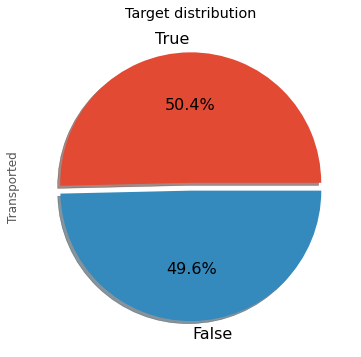

In [10]:
# Figure size
plt.figure(figsize=(6,6))

# Pie plot
df['Transported'].value_counts().plot.pie(explode=[0.03,0.03], autopct='%1.1f%%', shadow=True, textprops={'fontsize':16}).set_title("Target distribution")

Target varaible is quite balanced, hence we don't need to perform over/undersampling.

Now let's describe categorical features:

In [11]:
df.describe(include=[object])

,PassengerId,HomePlanet,Cabin,Destination,Name
count,8693,8693,8693,8693,8693
unique,8693,3,6560,3,8473
top,0001_01,Earth,G/734/S,TRAPPIST-1e,Alraium Disivering
freq,1,4803,207,6097,202


Let's now replace the strings in these categorical features by numbers. Pandas offers a `get_dummies` method to convert these to numbers so that we can multiply them with weights. It's basically one-hot coding, letting the model know the unqiue levels available in a particular.

We only process HomePlanet and Destination via `get_dummies`because others simply have too many unique values (aka levels).

In [12]:
df = pd.get_dummies(df, columns=["HomePlanet", "Destination"])
df.columns

Index(['PassengerId', 'CryoSleep', 'Cabin', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name',
       'Transported', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e'],
      dtype='object')

Our dummy columns are visible at the end of the dataframe!

Looking at numerical features:

In [13]:
df.describe(include=(np.number))

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e
count,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000,8693.000000
mean,28.728517,220.009318,448.434027,169.572300,304.588865,298.261820,0.552514,0.245140,0.202347,0.207063,0.091568,0.701369
std,14.355438,660.519050,1595.790627,598.007164,1125.562559,1134.126417,0.497263,0.430195,0.401772,0.405224,0.288432,0.457684
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,37.000000,41.000000,61.000000,22.000000,53.000000,40.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Samuel's notebook uncovered the following useful insight regarding `Age`. Let's visualize the feature first:

Text(0.5, 0, 'Age (years)')

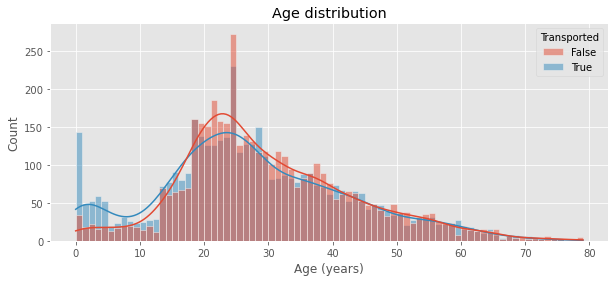

In [14]:
plt.figure(figsize=(10,4))

# Histogram
sns.histplot(data=df, x='Age', hue='Transported', binwidth=1, kde=True)

# Aesthetics
plt.title('Age distribution')
plt.xlabel('Age (years)')

Notes and insights by Samuel:

*Notes:*
* 0-18 year olds were **more** likely to be transported than not.
* 18-25 year olds were **less** likely to be transported than not.
* Over 25 year olds were about **equally** likely to be transported than not.

*Insight:*
* Create a new feature that indicates whether the passanger is a child, adolescent or adult.


In [15]:
p_groups = ['child', 'young', 'adult']

df['age_group'] = np.nan


    
        

In [16]:
df.loc[df['Age'] < 18, 'age_group'] = p_groups[0]
df.loc[(df['Age'] >= 18) & (df['Age'] <= 25), 'age_group'] = p_groups[1]
df.loc[df['Age'] > 25, 'age_group'] = p_groups[2]

In [17]:
df.head()

,PassengerId,CryoSleep,Cabin,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,age_group
0,0001_01,False,B/0/P,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0,1,0,0,0,1,adult
1,0002_01,False,F/0/S,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,1,0,0,0,0,1,young
2,0003_01,False,A/0/S,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0,1,0,0,0,1,adult
3,0003_02,False,A/0/S,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0,1,0,0,0,1,adult
4,0004_01,False,F/1/S,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,1,0,0,0,0,1,child


Now we need dummies for `age_group` as well:

In [18]:
df = pd.get_dummies(df, columns=["age_group"])
df.head()

,PassengerId,CryoSleep,Cabin,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Transported,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,age_group_adult,age_group_child,age_group_young
0,0001_01,False,B/0/P,39.0,False,0.0,0.0,0.0,0.0,0.0,...,False,0,1,0,0,0,1,1,0,0
1,0002_01,False,F/0/S,24.0,False,109.0,9.0,25.0,549.0,44.0,...,True,1,0,0,0,0,1,0,0,1
2,0003_01,False,A/0/S,58.0,True,43.0,3576.0,0.0,6715.0,49.0,...,False,0,1,0,0,0,1,1,0,0
3,0003_02,False,A/0/S,33.0,False,0.0,1283.0,371.0,3329.0,193.0,...,False,0,1,0,0,0,1,1,0,0
4,0004_01,False,F/1/S,16.0,False,303.0,70.0,151.0,565.0,2.0,...,True,1,0,0,0,0,1,0,1,0


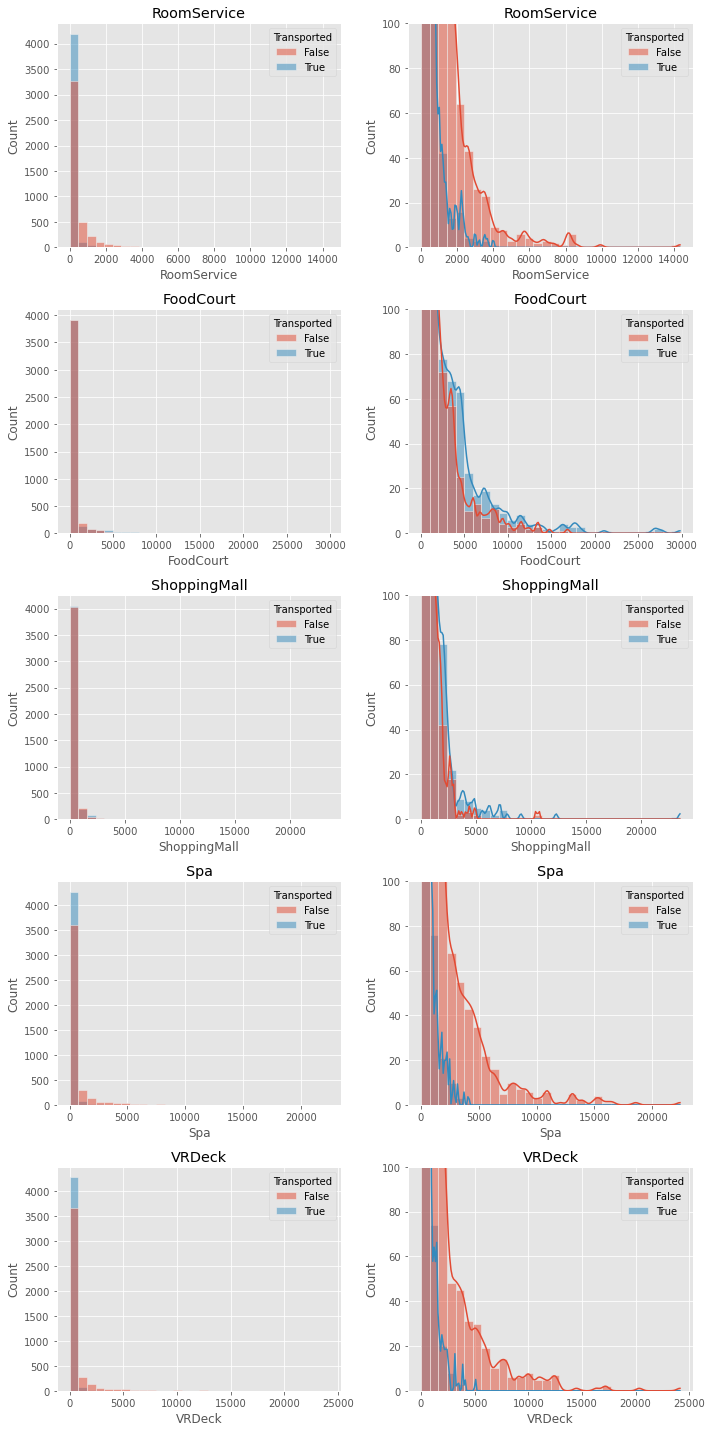

In [19]:
# Expenditure features
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot expenditure features
fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(exp_feats):
    # Left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=df, x=var_name, axes=ax, bins=30, kde=False, hue='Transported')
    ax.set_title(var_name)
    
    # Right plot (truncated)
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=df, x=var_name, axes=ax, bins=30, kde=True, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)
fig.tight_layout()  # Improves appearance a bit
plt.show()

Insights:

- Luxuries such as VR decl and Spa were clearly more used by people who were NOT transported.
- Need to create a log form for all the above to reduce the skew of the distributions.

In [20]:
for f in exp_feats:
    df[f'log{f}'] = np.log(df[f]+1)

In [21]:
df.head()

,PassengerId,CryoSleep,Cabin,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,age_group_adult,age_group_child,age_group_young,logRoomService,logFoodCourt,logShoppingMall,logSpa,logVRDeck
0,0001_01,False,B/0/P,39.0,False,0.0,0.0,0.0,0.0,0.0,...,0,1,1,0,0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0002_01,False,F/0/S,24.0,False,109.0,9.0,25.0,549.0,44.0,...,0,1,0,0,1,4.700480,2.302585,3.258097,6.309918,3.806662
2,0003_01,False,A/0/S,58.0,True,43.0,3576.0,0.0,6715.0,49.0,...,0,1,1,0,0,3.784190,8.182280,0.000000,8.812248,3.912023
3,0003_02,False,A/0/S,33.0,False,0.0,1283.0,371.0,3329.0,193.0,...,0,1,1,0,0,0.000000,7.157735,5.918894,8.110728,5.267858
4,0004_01,False,F/1/S,16.0,False,303.0,70.0,151.0,565.0,2.0,...,0,1,0,1,0,5.717028,4.262680,5.023881,6.338594,1.098612


Finally, we are splitting `PassengerId` as per its data description:

In [22]:
# New feature - Group
df['Group'] = df['PassengerId'].apply(lambda x: x.split('_')[0]).astype(int)

In [23]:
df.columns

Index(['PassengerId', 'CryoSleep', 'Cabin', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name',
       'Transported', 'HomePlanet_Earth', 'HomePlanet_Europa', 'HomePlanet_Mars', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22',
       'Destination_TRAPPIST-1e', 'age_group_adult', 'age_group_child', 'age_group_young', 'logRoomService', 'logFoodCourt',
       'logShoppingMall', 'logSpa', 'logVRDeck', 'Group'],
      dtype='object')

In [24]:
added_cols = ['HomePlanet_Earth', 'HomePlanet_Europa','HomePlanet_Mars', 'Destination_55 Cancri e', 'Destination_PSO J318.5-22', 'Destination_TRAPPIST-1e','age_group_adult', 'age_group_child', 'age_group_young', 'logRoomService', 'logFoodCourt',
       'logShoppingMall', 'logSpa', 'logVRDeck', 'Group']

In [25]:
df[added_cols].head()

,HomePlanet_Earth,HomePlanet_Europa,HomePlanet_Mars,Destination_55 Cancri e,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,age_group_adult,age_group_child,age_group_young,logRoomService,logFoodCourt,logShoppingMall,logSpa,logVRDeck,Group
0,0,1,0,0,0,1,1,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,1
1,1,0,0,0,0,1,0,0,1,4.700480,2.302585,3.258097,6.309918,3.806662,2
2,0,1,0,0,0,1,1,0,0,3.784190,8.182280,0.000000,8.812248,3.912023,3
3,0,1,0,0,0,1,1,0,0,0.000000,7.157735,5.918894,8.110728,5.267858,3
4,1,0,0,0,0,1,0,1,0,5.717028,4.262680,5.023881,6.338594,1.098612,4


What about `CryoSleep`?

In [26]:
df.CryoSleep.unique()

array([False,  True])

It's boolean, so we can mulitply with weights. VIP looks the same.

In [27]:
indep_cols = ['Age', 'CryoSleep', 'VIP'] + added_cols

## Setting up a linear model

Single layer neural network with one neuron:

In [28]:
np.random.seed(442)
weights = np.random.randn(len(indep_cols), 1)
bias = np.random.randn(1)

In [29]:
preds = np.dot(df[indep_cols].values, weights)

In [30]:
preds.shape

(8693, 1)

In [31]:
trn_indep = np.array(df[indep_cols], dtype='float32')
trn_dep = np.array(df['Transported'], dtype='float32')

In [32]:
print(trn_indep.shape)
print(trn_dep.shape)

(8693, 18)
(8693,)


Single layer neural network with three neurons(slides are copied from nnfs.io video):

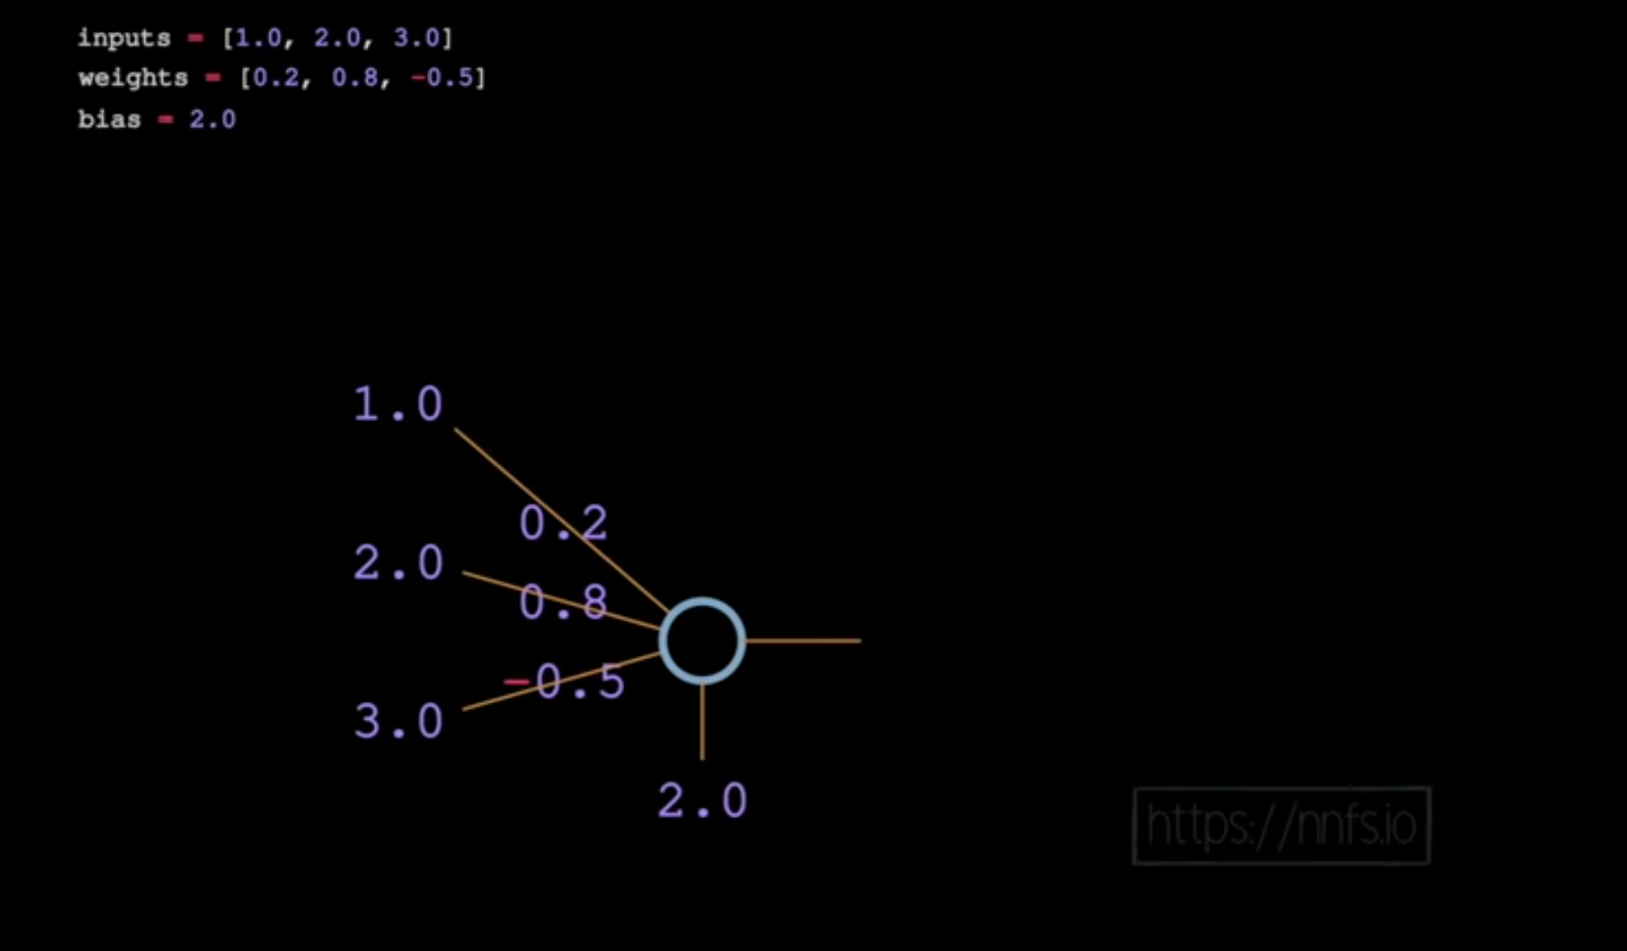

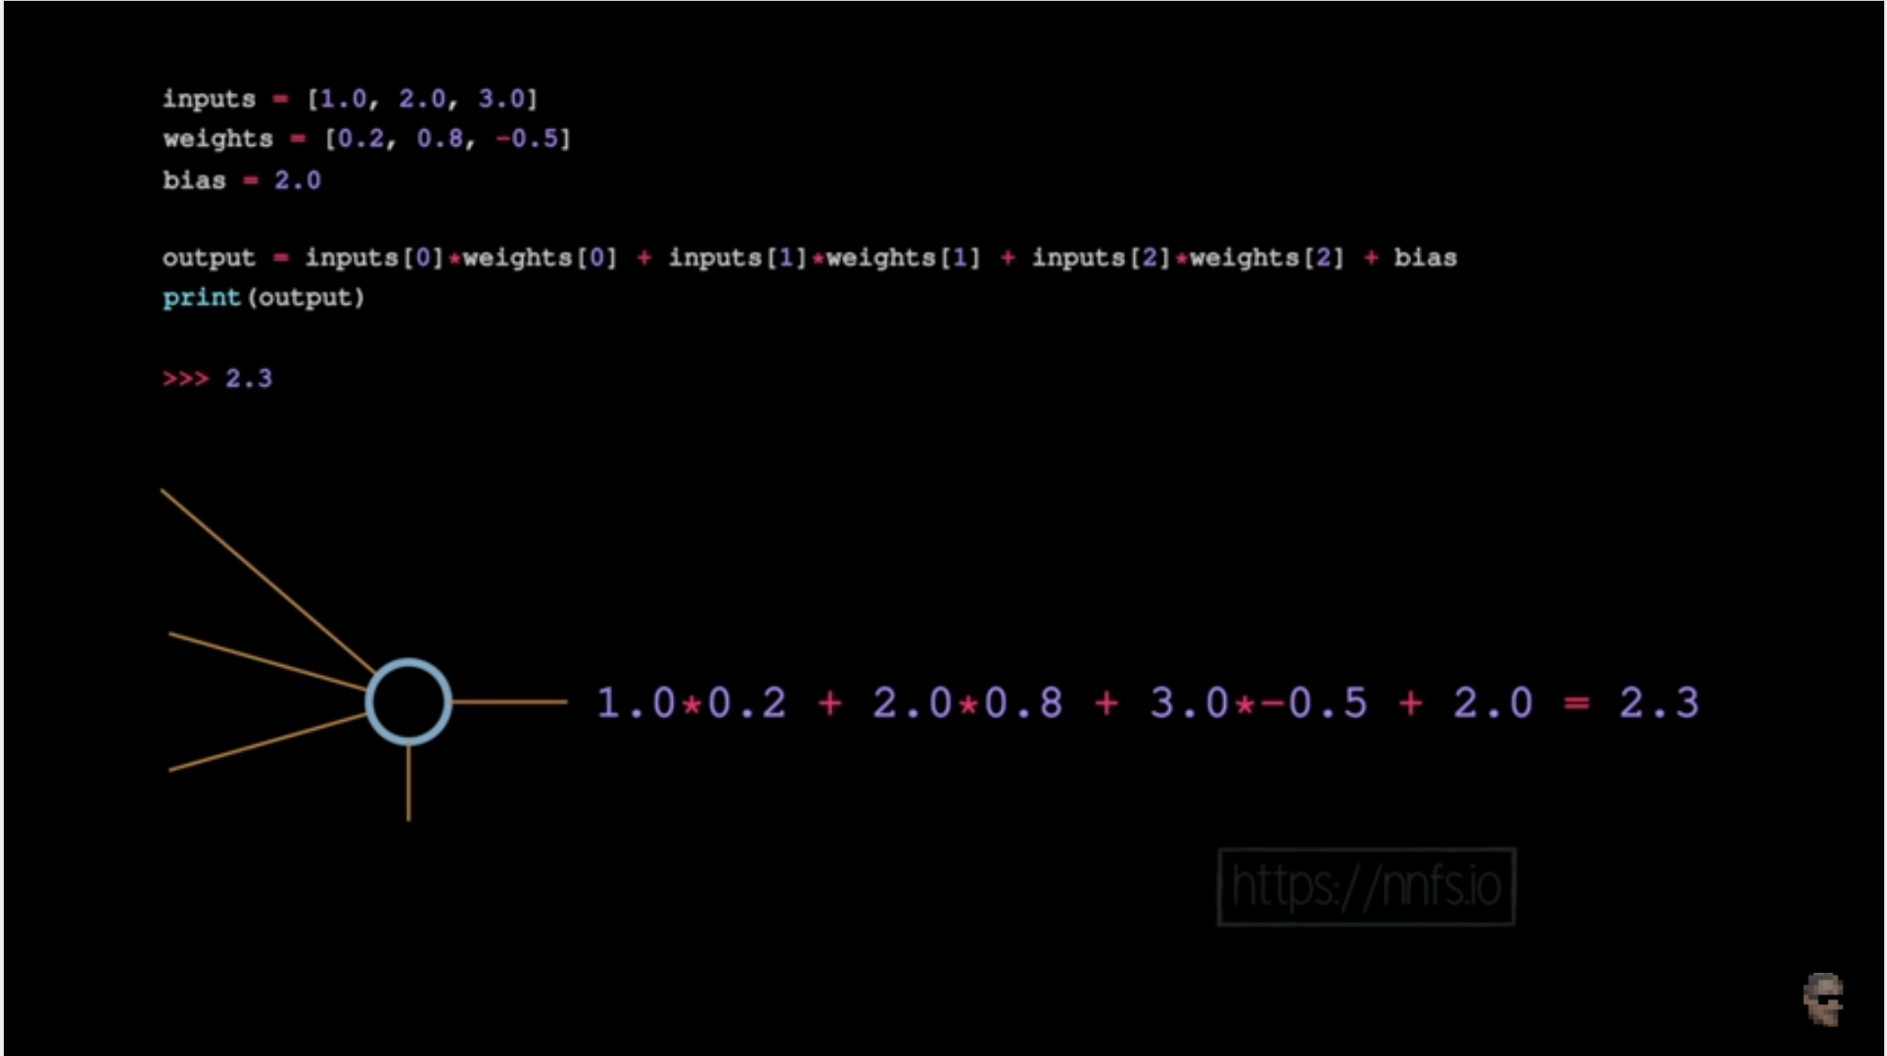

In [33]:
np.random.seed(442)
weights = np.random.randn(len(indep_cols), 3) #three neurons in this layer
bias = np.random.randn(1, 3)

In [34]:
bias

array([[ 0.01176998, -0.85427749, -0.99987562]])

In [35]:
preds = np.dot(df[indep_cols].values, weights) + bias

In [36]:
preds.shape

(8693, 3)

In [37]:
preds[:10]

array([[-48.06963390253141, -18.290557540354897, 25.89840533681499],
       [-37.91377002769904, -7.504076537856783, 19.929613327882404],
       [-77.52103870477566, -16.739210482170467, 48.30474706150288],
       [-49.956656061980745, -2.8342719146155777, 27.74823775227435],
       [-27.921019655098725, -0.8518280063674349, 7.996057055720733],
       [-58.52447309612352, -11.829816864262263, 30.01637869888577],
       [-43.57861207919503, -3.600338170392331, 14.143030534080323],
       [-42.93381590139605, -11.247805747916502, 13.576656755604825],
       [-53.425588340898884, -4.639261738916223, 17.59311661596172],
       [-25.380443498116176, -10.613520203166267, 1.9029395296299394]], dtype=object)

A deeper neural network with 2 hidden layers and an output layer:

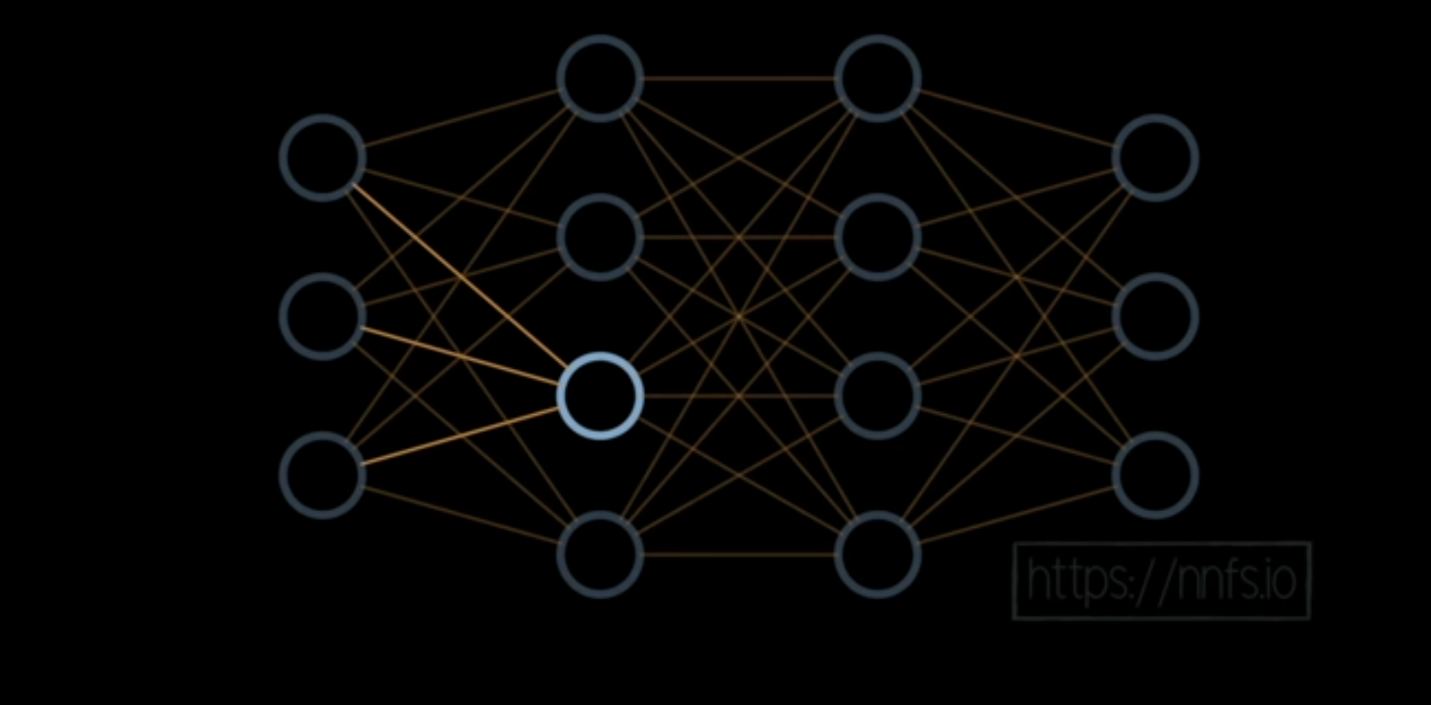

In [38]:
trn_dep = torch.tensor(trn_dep, dtype=torch.long)
trn_indep = torch.tensor(trn_indep, dtype=torch.float)

In [39]:
trn_indep.shape

torch.Size([8693, 18])

In [40]:
trn_dep.shape

torch.Size([8693])

In [41]:
#collapse_output
trn_indep[:5]


tensor([[39.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  4.7005,  2.3026,
          3.2581,  6.3099,  3.8067,  2.0000],
        [58.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  3.7842,  8.1823,
          0.0000,  8.8122,  3.9120,  3.0000],
        [33.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  7.1577,
          5.9189,  8.1107,  5.2679,  3.0000],
        [16.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  5.7170,  4.2627,
          5.0239,  6.3386,  1.0986,  4.0000]])

In [42]:
vals,indices = trn_indep.max(dim=0)
trn_indep = trn_indep / vals

Next let's define our layers, I'm going to define them as classes, so that we can reuse objects of each classes when needed. 

In [43]:
#linear layer class
class linearlayer:
    def __init__(self, n_inputs, n_neurons):
        self.weights = ((torch.rand(n_inputs, n_neurons)-0.3)/n_neurons)*4
        self.weights = self.weights.requires_grad_()
        self.biases = ((torch.rand(1, n_neurons))-0.5)*0.1
        self.biases = self.biases.requires_grad_()
    def forward(self, inputs):
        self.output = inputs@self.weights + self.biases
    
        
        

In [44]:
#ReLU activation function
class ReLU_act:
    def forward(self, inputs):
        self.output = torch.clip(inputs, 0.)

In [45]:
#Softmax - for the last layer
class Softmax_act:
    def forward(self, inputs):
        exp_values = torch.exp(inputs)
        probs = exp_values/torch.sum(exp_values, axis=1, keepdims=True)
        self.output = probs

Why do we use softmax for the last layer of our Deep learning network?

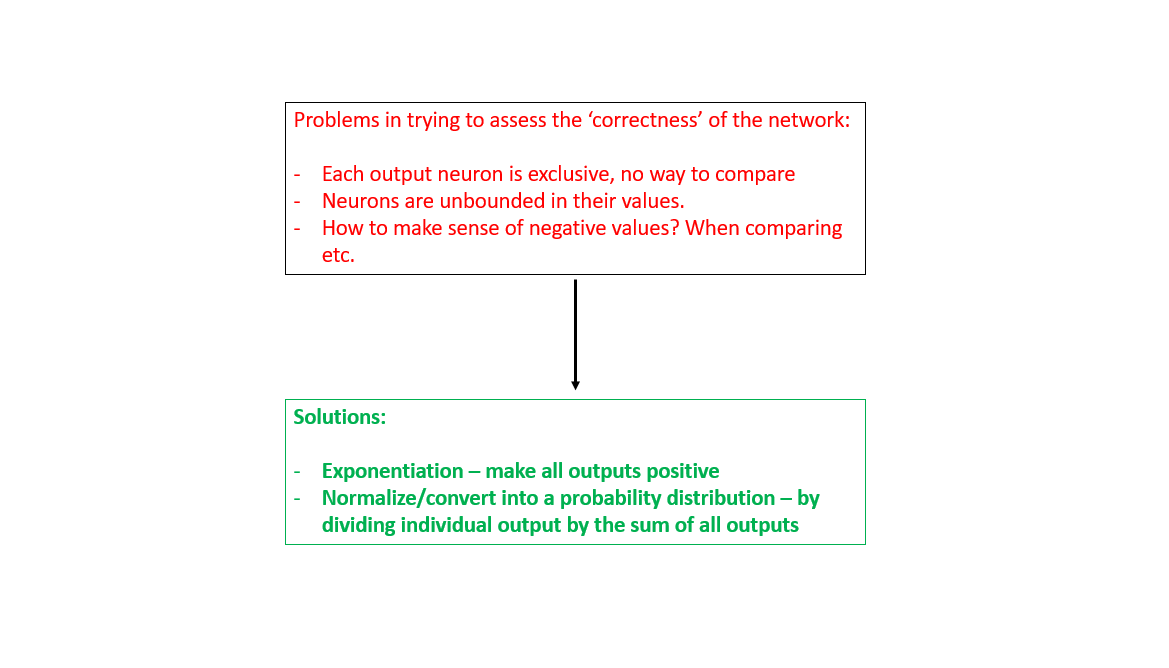

In [46]:
n_inputs=len(indep_cols)
n_hidden=10
inputs=trn_indep
y_true=trn_dep

In [47]:
n_inputs

18

Initializing the parameters of our network:

In [48]:
    #collapse_output
    layer1 = linearlayer(n_inputs, n_hidden)
    relu1 = ReLU_act()
    layer2 = linearlayer(n_hidden, n_hidden)
    relu2 = ReLU_act()
    layer3 = linearlayer(n_hidden, 2)
    wandbs = layer1.weights, layer2.weights, layer3.weights, layer1.biases, layer2.biases, layer3.biases
    print('These are our weights and biases:')
    print(wandbs)
    layer1.forward(inputs)
    print("\n")
    print('These are our l1 outputs:')
    print(layer1.output)
    relu1.forward(layer1.output)
    print("\n")
    print('These are our r1 outputs:')
    print(relu1.output)
    layer2.forward(relu1.output)
    print("\n")
    print('These are our l2 outputs:')
    print(layer2.output)
    relu2.forward(layer2.output)
    print("\n")
    print('These are our r2 outputs:')
    print(relu2.output)
    layer3.forward(relu2.output)
    print("\n")
    print('These are our l3 outputs:')
    print(layer3.output)
    softmax = Softmax_act()
    softmax.forward(layer3.output)
    
    print("\n")
    print('These are our softmax outputs:')
    print(softmax.output)
    
    

These are our weights and biases:
(tensor([[ 0.0260, -0.1157, -0.0653,  0.1403,  0.1002,  0.1333,  0.1741,  0.1566,  0.1276, -0.1129],
        [ 0.0760,  0.1800,  0.2590,  0.0688, -0.0477, -0.1007,  0.0661,  0.0095,  0.1469,  0.1296],
        [ 0.1705,  0.2295, -0.0329, -0.0517, -0.0632,  0.0811,  0.2174,  0.0709, -0.0540, -0.0168],
        [-0.1047, -0.0153,  0.1489,  0.2327,  0.1738,  0.0153, -0.0664,  0.0524,  0.2173,  0.1926],
        [ 0.0996,  0.1585, -0.0161, -0.0814,  0.1414, -0.0998,  0.2182, -0.0818,  0.1015,  0.0761],
        [ 0.1157, -0.0088, -0.0468,  0.0828, -0.0404, -0.0981, -0.0587, -0.0822,  0.2706, -0.0392],
        [-0.0315,  0.1820,  0.2051,  0.0203,  0.0709,  0.2708,  0.1082, -0.0628, -0.0355,  0.1986],
        [ 0.1663,  0.0526,  0.0863,  0.1402,  0.0934,  0.2441,  0.2029, -0.0690,  0.0848,  0.0656],
        [-0.0209,  0.2383,  0.2429,  0.2582, -0.0006,  0.2111, -0.0356, -0.1101, -0.0517,  0.2238],
        [-0.0547,  0.0079, -0.1143,  0.1253, -0.1049,  0.1041,  0

In [49]:
y_preds = softmax.output


In [50]:
#hide
wandbs

(tensor([[ 0.0260, -0.1157, -0.0653,  0.1403,  0.1002,  0.1333,  0.1741,  0.1566,  0.1276, -0.1129],
         [ 0.0760,  0.1800,  0.2590,  0.0688, -0.0477, -0.1007,  0.0661,  0.0095,  0.1469,  0.1296],
         [ 0.1705,  0.2295, -0.0329, -0.0517, -0.0632,  0.0811,  0.2174,  0.0709, -0.0540, -0.0168],
         [-0.1047, -0.0153,  0.1489,  0.2327,  0.1738,  0.0153, -0.0664,  0.0524,  0.2173,  0.1926],
         [ 0.0996,  0.1585, -0.0161, -0.0814,  0.1414, -0.0998,  0.2182, -0.0818,  0.1015,  0.0761],
         [ 0.1157, -0.0088, -0.0468,  0.0828, -0.0404, -0.0981, -0.0587, -0.0822,  0.2706, -0.0392],
         [-0.0315,  0.1820,  0.2051,  0.0203,  0.0709,  0.2708,  0.1082, -0.0628, -0.0355,  0.1986],
         [ 0.1663,  0.0526,  0.0863,  0.1402,  0.0934,  0.2441,  0.2029, -0.0690,  0.0848,  0.0656],
         [-0.0209,  0.2383,  0.2429,  0.2582, -0.0006,  0.2111, -0.0356, -0.1101, -0.0517,  0.2238],
         [-0.0547,  0.0079, -0.1143,  0.1253, -0.1049,  0.1041,  0.2544,  0.1405,  0.0803, 

## Defining our loss function:

Negative log loss is going to be our loss function. We use our predictions from softmax to calculate the loss. I won't bore youwith all the explanations. That is done in the resources I mentioned above, in a better way than I ever can.

In [51]:
class negative_log_loss:
    def calculate(self, y_preds, y_true):
        samples = len(y_preds)
        y_pred_clipped = torch.clip(y_preds, 1e-7, 1-1e-7)
        
        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[torch.tensor(range(samples)), y_true]
           
        elif len(y_true.shape) == 2:
            correct_confidences = torch.sum(y_pred_clipped*y_true, axis=1)
        negative_log_likelihoods = -torch.log(correct_confidences)
        return torch.mean(negative_log_likelihoods)

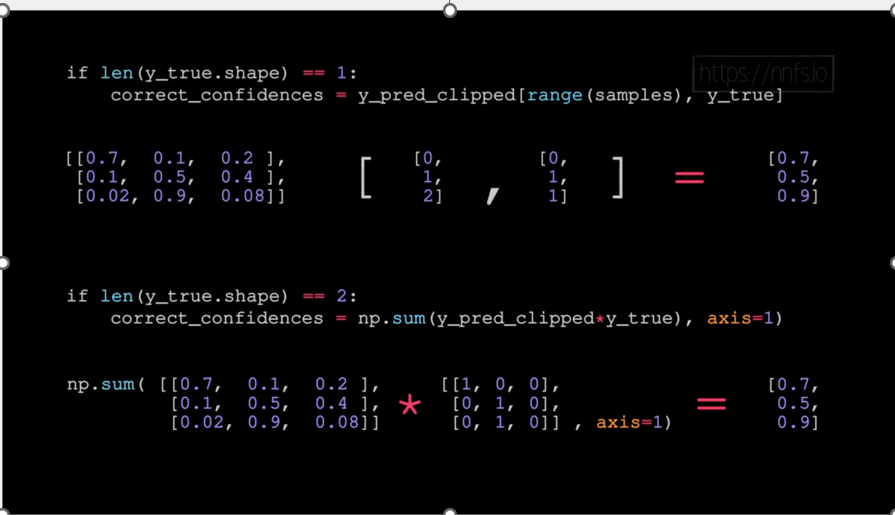

## 'Training' our neural network

First we are gonna write a function to update our weights and biases according to our loss(i.e. by reducing the product of the gradient and learning rate by our w&bs.)

In [52]:
def update_wandbs(wandbs, lr):
    for layer in wandbs:
        layer.sub_(layer.grad * lr)
        #print(layer.grad)
        layer.grad.zero_()

Then we write a training loop for our network, to train for one 'epoch'.

In [53]:
def one_epoch(wandbs, lr, inputs):
    layer1.weights, layer2.weights, layer3.weights, layer1.biases, layer2.biases, layer3.biases = wandbs
    #print('These are our weights and biases:')
    #print(wandbs)
    layer1.forward(inputs)
    #print("\n")
    #print('These are our l1 outputs:')
    #print(layer1.output)
    relu1.forward(layer1.output)
    #print("\n")
    #print('These are our r1 outputs:')
    #print(relu1.output)
    layer2.forward(relu1.output)
    #print("\n")
    #print('These are our l2 outputs:')
    #print(layer2.output)
    relu2.forward(layer2.output)
    #print("\n")
    #print('These are our r2 outputs:')
    #print(relu2.output)
    layer3.forward(relu2.output)
    #print("\n")
    #print('These are our l3 outputs:')
    #print(layer3.output)
    softmax = Softmax_act()
    softmax.forward(layer3.output)
    y_preds = softmax.output
    #print("\n")
    #print('These are our softmax outputs:')
    #print(softmax.output)
    nll = negative_log_loss()
    loss = nll.calculate(y_preds, y_true)
    loss.backward()
    with torch.no_grad(): update_wandbs(wandbs, 2)
    print(f"{loss:.3f}", end="; ")

Then, we define another function so that we can train the model easily for multiple epochs. Learning rate is an important hyperparameter here. Refer to Jeremy's notebooks/videos if you don't already know about it.

In [54]:
def train_model(wandbs, lr, inputs, epochs=30):
    #torch.manual_seed(442)
    for i in range(epochs): one_epoch(wandbs, lr, inputs)
    return y_preds

In [55]:
y_preds = train_model(wandbs, 0.5, inputs, epochs=40)

0.759; 3.276; 0.955; 0.700; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 0.693; 

In [56]:
y_preds

tensor([[0.4426, 0.5574],
        [0.2850, 0.7150],
        [0.4559, 0.5441],
        [0.4255, 0.5745],
        [0.3119, 0.6881],
        [0.4123, 0.5877],
        [0.2759, 0.7241],
        ...,
        [0.4241, 0.5759],
        [0.4024, 0.5976],
        [0.5456, 0.4544],
        [0.3459, 0.6541],
        [0.3341, 0.6659],
        [0.5035, 0.4965],
        [0.3800, 0.6200]], grad_fn=<DivBackward0>)

In [57]:
def accuracy(y_preds, y_true):
    samples = len(y_preds)
    return print(f'Accuracy is {(y_true.bool()==(y_preds[torch.tensor(range(samples)), y_true]>0.5)).float().mean()*100 :.3f} percent')

In [58]:
accuracy(y_preds, y_true)

Accuracy is 97.550 percent


Well, My network is still pretty crappy. I tried a lot, but couldn't get it to train yet. I'm gonna keep trying. But for now, I'm going to use [a framework](https://www.kaggle.com/code/jhoward/why-you-should-use-a-framework) to make my life easier. Afterall, purpose of this whole exercise was not to get an accurate model, but to understand the nuts and bolts of a neural network!